In [ ]:
!pip install --upgrade --no-deps statsmodels

     |████████████████████████████████| 9.5MB 31.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

import itertools

from tqdm.notebook import tqdm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.deterministic import DeterministicProcess

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

%config IPCompleter.greedy=True

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [ ]:
path = '/content/drive/MyDrive/SDMaTSA'
df = pd.read_csv(path+'/TrainingSet.csv' , index_col=False, sep=";", parse_dates=['DATA'])

In [ ]:
df.head()

,DATA,Ora,VALORE
0,2018-09-01,1,3646742
1,2018-09-01,2,3273110
2,2018-09-01,3,3069245
3,2018-09-01,4,2969621
4,2018-09-01,5,2944116


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    17518 non-null  datetime64[ns]
 1   Ora     17518 non-null  int64         
 2   VALORE  17518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 410.7 KB


In [ ]:
# Trasformazione delle ore e creazione della colonna datetime
df['Ora'] = df['Ora'] - 1
df['Ora'] = df['Ora'].astype(str)
df['datetime'] = pd.to_datetime(df['DATA'].astype(str) + '-' + df['Ora'], 
                                format = "%Y-%m-%d-%H")

In [ ]:
# Utilizzo di tutte le date come indice del dataframe, in questo modo si possono
# individuare dei valori mancanti per specifiche date
range_date = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='H')
range_date = range_date.to_frame()
range_date.columns = ['datetime']
df = pd.merge(range_date, df, how='left', on='datetime')
df.set_index(df['datetime'], inplace=True)

In [ ]:
# Per gestire l'ora legale, come suggerito dal fornitore dei dati, 
# si rimpiazzano le ore mancanti con il valore dell'ora precedente
df.at["2019-03-31 02:00:00", 'VALORE'] = df.loc["2019-03-31 01:00:00", 'VALORE']
df.at["2020-03-29 02:00:00", 'VALORE'] = df.loc["2020-03-29 01:00:00", 'VALORE']

In [ ]:
# Per il giorno mancante, domenica 31-05-2020, si calcola la media dei valori 
# della domenica precedente e successiva per le stesse ore
for i in pd.date_range(start="2020-05-31 00:00:00", end="2020-05-31 23:00:00", freq='H'):
    df.at[i,'VALORE']=(
        df.loc[pd.to_datetime(i)-datetime.timedelta(days=7),'VALORE']+
        df.loc[pd.to_datetime(i)+datetime.timedelta(days=7),'VALORE'])/2

### Creazione dei regressori

Si creano delle colonne aggiuntive dalla data usate sia per la creazione dei regressori che per i successivi grafici

In [ ]:
df['DATA'] = df.index.date
df['Ora'] = df.index.hour
df['Year']=df.index.year
df['Month']=df.index.month
df['Dayofweek']=df.index.day_name()
df['hour_of_the_week'] = df['datetime'].dt.dayofweek * 24 + (df['datetime'].dt.hour)
df['Week'] = df.index.strftime("%V").astype(int)
df['Day']=df.index.day
df['Hour']=df.index.hour

In [ ]:
# Creazione del regressore delle vacanze tramite il pacchetto Holiday
IT_holidays = holidays.CountryHoliday('IT')
df['is_holiday'] = df['datetime'].apply(lambda x: 1 if x in IT_holidays else 0)

In [ ]:
# Creazione del regressore dei weekend
df['is_weekend'] = df['Dayofweek'].apply(
    lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

In [ ]:
# Creazione del regressore lockdown
lockdown_range = pd.date_range(start="2020-03-09", end="2020-05-18", freq='D')
df['lockdown'] = df['DATA'].apply(lambda x: 1 if x in lockdown_range else 0)

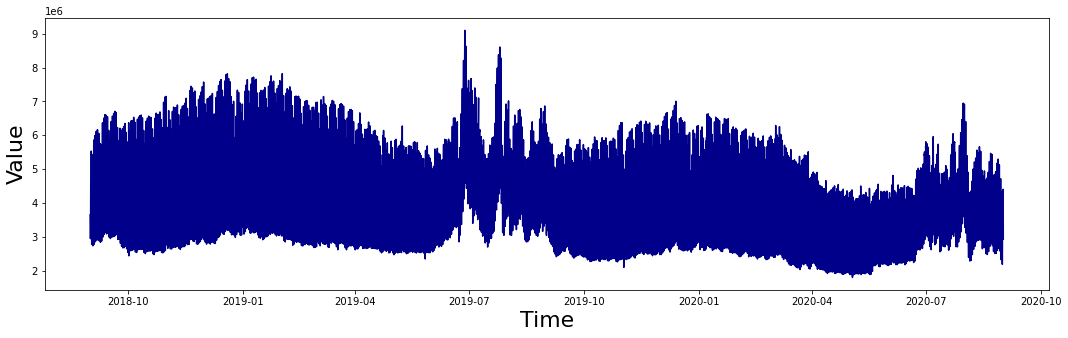

In [ ]:
# Plot dell'intera sarie
plt.figure(figsize=(18, 5))
plt.plot(df['VALORE'], color='darkblue')
plt.ylabel('VALORE', fontsize = 12)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.show()

### Analsi sagionalità
Vengono mostrari dei grafici per studiare la stagionalità annuale, mensile, settimanale, gioraliera

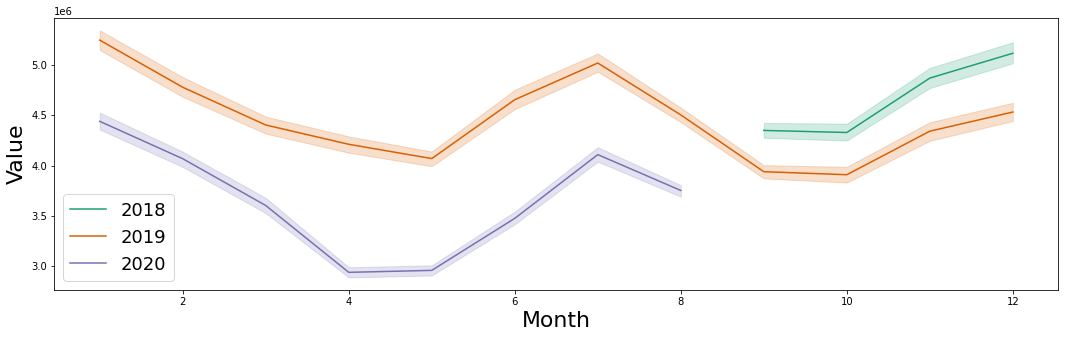

In [ ]:
# Stagionalità annuale della serie per i tre anni di osservazione
plt.figure(figsize=(18, 5))
sns.lineplot(x=df['Month'], y=df['VALORE'], hue=df['Year'], palette='Dark2')
plt.xlabel('Month', fontsize = 22)
plt.ylabel('Value', fontsize = 22)
plt.legend(prop={'size': 18})
plt.show()

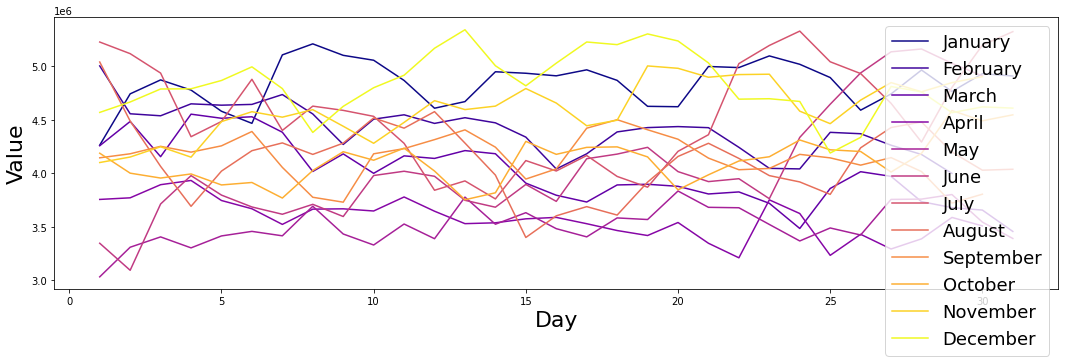

In [ ]:
# Stagionalità mensile
plt.figure(figsize=(18, 5))
sns.lineplot(x=df['Day'], y=df['VALORE'], hue=df['Month'], ci=None, palette="plasma")
plt.xlabel('Day', fontsize = 22)
plt.ylabel('Value', fontsize = 22)
plt.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], prop={'size': 18})
plt.show()

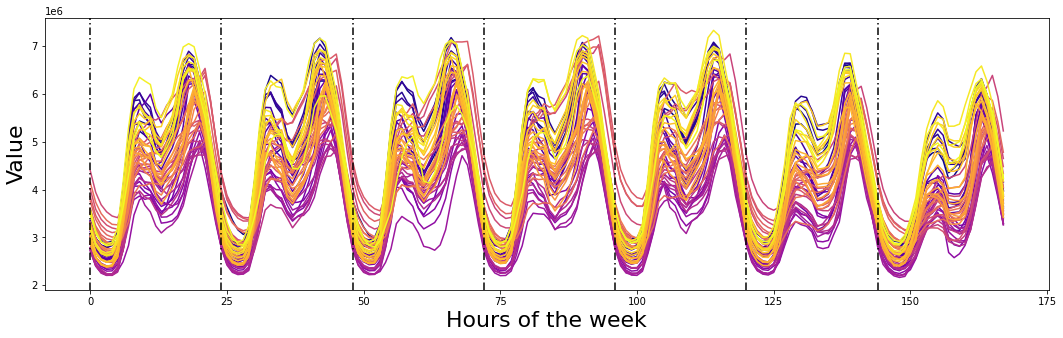

In [ ]:
# Stagionalità settimanale
plt.figure(figsize=(18, 5))
sns.lineplot(x=df['hour_of_the_week'], y=df['VALORE'], hue=df['Week'], ci=None, palette="plasma", legend=False)
for xc in range(0, 24*7, 24):
    plt.axvline(x=xc, color='black', dashes=(5, 2, 1, 2))
plt.xlabel('Hours of the week', fontsize = 22)
plt.ylabel('Value', fontsize = 22)
plt.show()

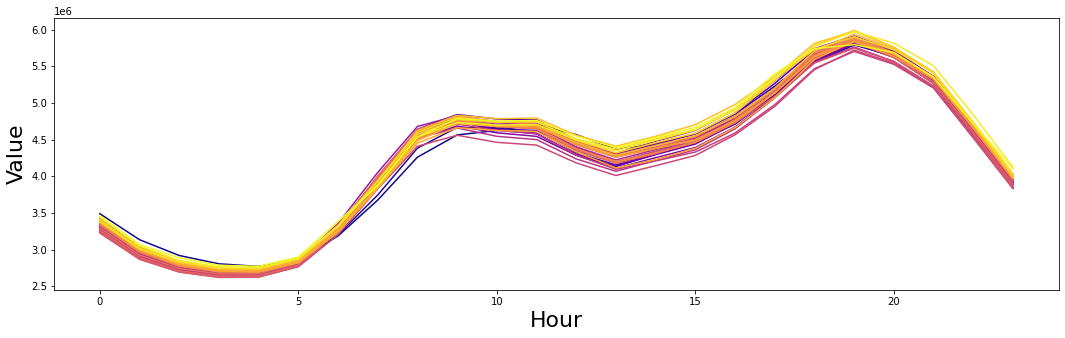

In [ ]:
# Stagionalità giornaliera
plt.figure(figsize=(18, 5))
sns.lineplot(x=df['Hour'], y=df['VALORE'], hue=df['Day'], ci=None, palette="plasma", legend=None)
plt.xlabel('Hour', fontsize = 22)
plt.ylabel('Value', fontsize = 22)
plt.show()

Si può vedere una stagionalità annua con un trand decrescente, una stagionalità settimanale e giornaliera. Sembra essente, invece, la stagioalità mensile.

### Divisione in Train e Validation set

Generalmante viene usata una divisione del 80% per il train e 20% per il validation, tuttavia si è scelto di inserire nel train anche i primi due mesi del lockdown per avere delle previsioni più precise considerando questo evento eccezionale.

In [ ]:
# si divide il dataset in train set e test set
train=df.loc[:"2020-04-30 23:00:00"]
validation=df.loc["2020-05-01 00:00:00":]

In [ ]:
print(f'Dim. Train set: {train.shape[0]}, % sul totale: {round((train.shape[0]/df.shape[0])*100, 2)}%')
print(f'Dim. Validation set: {validation.shape[0]}, % sul totale: {round((validation.shape[0]/df.shape[0])*100, 2)}%')

Dim. Train set: 14592, % sul totale: 83.17%
Dim. Validation set: 2952, % sul totale: 16.83%


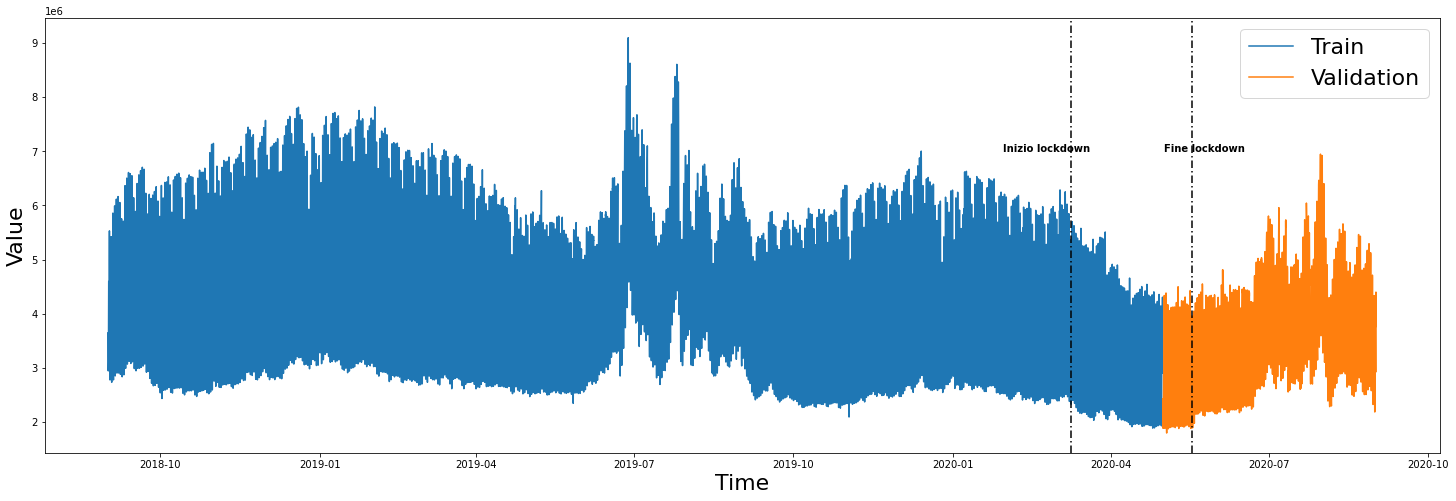

In [ ]:
# Plot della serie con la distinzione tra train e validation
plt.figure(figsize=(25, 8))
plt.plot(train['VALORE'])
plt.plot(validation['VALORE'])
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Value', fontsize = 22)
plt.legend(['Train', 'Validation'], prop={'size': 22})
plt.axvline(x=df.index[df.index=="2020-03-09 00:00:00"], color='black', dashes=(5, 2, 1, 2))
plt.text(df.index[df.index=="2020-01-30 00:00:00"], 7e06, 'Inizio lockdown',  fontdict=dict(weight='bold'), color='black')

plt.axvline(x=df.index[df.index=="2020-05-18 00:00:00"], color='black', dashes=(5, 2, 1, 2))
plt.text(df.index[df.index=="2020-05-01 10:00:00"], 7e06, 'Fine lockdown',  fontdict=dict(weight='bold'), color='black')

plt.show()

# Modello SARIMA

In questa sezione si descrive la scelta del modello SARIMA da usare, si parte con l’analisi della stazionariet`a della serie per capire se sia opportuno o menoapplicare delle trasformazioni o delle differenze alla serie.  Successivamente sitestano dei modelli per individuare il migliore

### Analisi della stazionarietà

La  condizione  di  stazionarietà  di  una  serie  è  un  requisito  importante  per utilizzare i modelli lineari. SI analizza la stazionarietà in media e in varianza utilizzado vari  test  o  tramite  l’esame  delle  funzioni  ACF  e  PACF.



Per prima cosa si analizza la stazionarietà in varianza, sembrerebbe che la relazione tra media e varianza per i giorni sia lineare. SI applica quindi una trasformazione logaritmica.

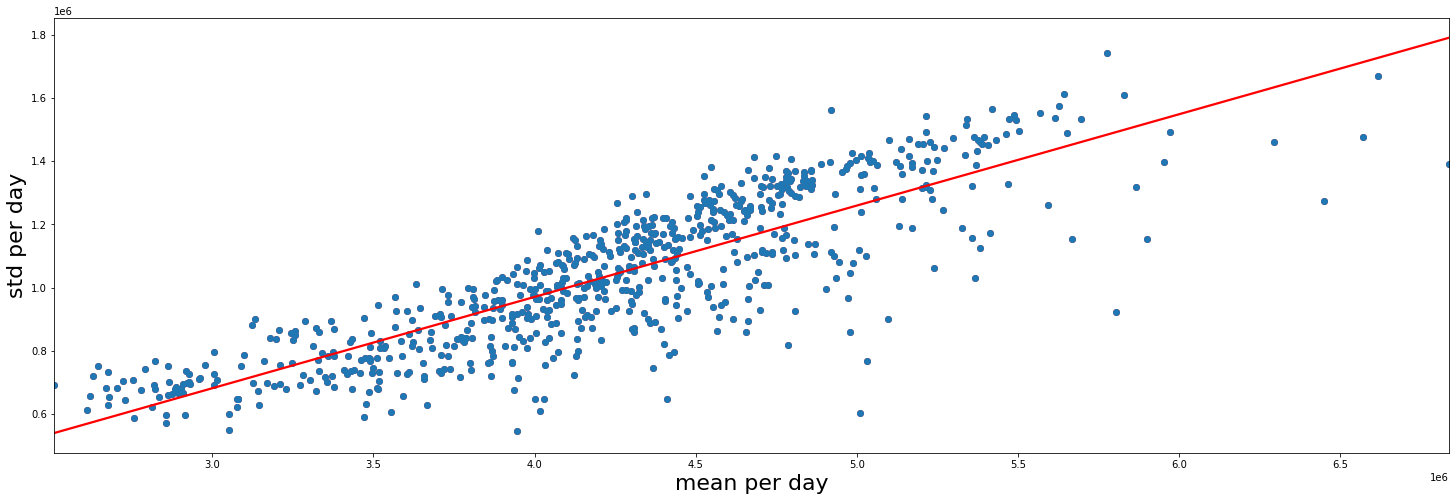

In [ ]:
pivot=df.pivot_table(index='DATA', values='VALORE', aggfunc=['mean', 'std'])

plt.figure(figsize=(25, 8))
plt.plot(pivot['mean'], pivot['std'], 'o')
sns.regplot(x='mean', y='std', data=pivot, ci=None, color='red')
plt.ylabel('std per day', fontsize = 22)
plt.xlabel('mean per day', fontsize = 22)
plt.show()

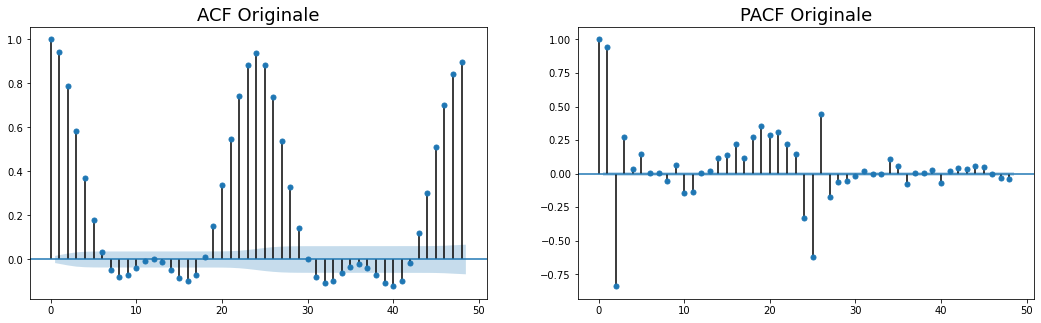

In [ ]:
# Si analizzano i correlogrammi. Nella ACF si vede un andamento 
# oscillatorio giornaliero ogni 24 ritardi
plt.rcParams.update({'figure.figsize':(18,5)})
fig1, axes1 = plt.subplots(1, 2, sharex=True)
plot_acf(train['VALORE'], lags=48, ax=axes1[0])
axes1[0].set_title('ACF Originale', fontsize = 18)
plot_pacf(train['VALORE'], lags=48, ax=axes1[1])
axes1[1].set_title('PACF Originale', fontsize = 18)

plt.show()

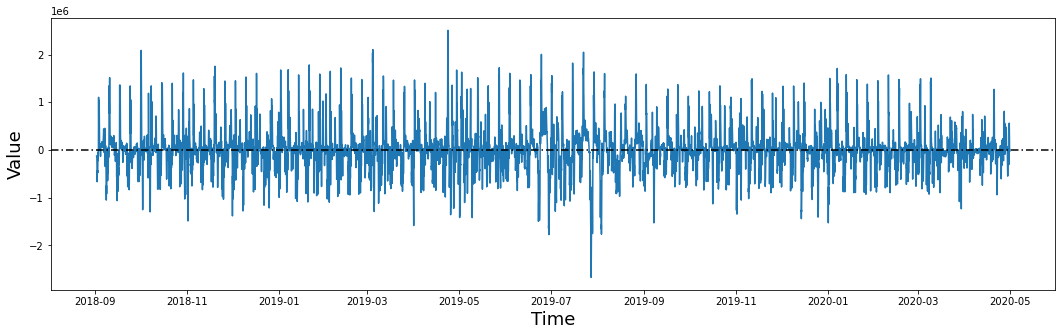

In [ ]:
# Si effettua una differenza a 24 lags e la serie sembra stazionaria
plt.figure(figsize=(18,5))
plt.plot(train['VALORE'].diff(24).dropna())
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Value', fontsize = 18)
plt.axhline(color='black', dashes=(5, 2, 1, 2))
plt.show()

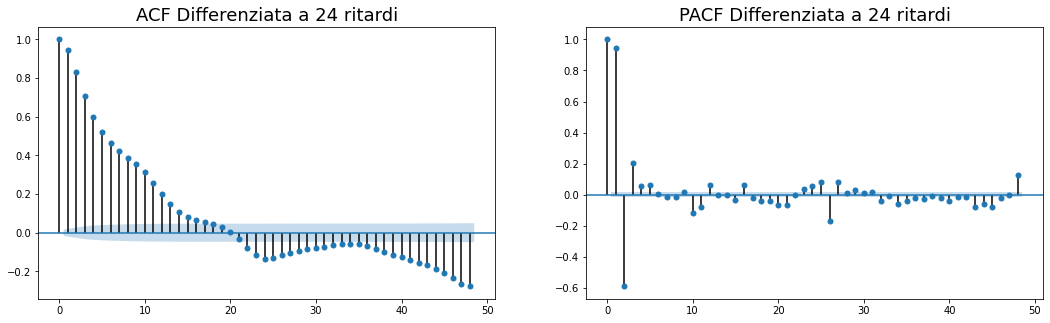

In [ ]:
# Si mostrano i correlogrammi della serie differenziata
plt.rcParams.update({'figure.figsize':(18,5)})
fig2, axes2 = plt.subplots(1, 2, sharex=True)
plot_acf(train['VALORE'].diff(24).dropna(), lags=48, ax=axes2[0])
axes2[0].set_title('ACF Differenziata a 24 ritardi', fontsize = 18)
plot_pacf(train['VALORE'].diff(24).dropna(), lags=48, ax=axes2[1])
axes2[1].set_title('PACF Differenziata a 24 ritardi', fontsize = 18)
plt.show()

Per verificare la stazionarietà della serie si effettua anche il test Augmented Dickey-Fuller. In base al livello di significatività di 0,05 e al p-value del test ADF, l'ipotesi nulla è rifiutata. Quindi, la serie è stazionaria secondo il test ADF. Il p-value è < 0.05 quindi si può rigettare l'ipotesi H0 che la serie non sia stazionaria

In [ ]:
def adf_test(data, cl=95):
    res = adfuller(data)
    print('ADF-test')
    print('--------')
    print(f'valore test: {res[0]}')
    print(f'p-value: {res[1]}')
    print(f'valore critico: {res[4][f"{100 - cl}%"]}')
    print(f'valore test > valore critico: {res[0] > res[4][f"{100 - cl}%"]}')
    print(f'p-value > {(100-cl)/100}: {res[1] > (100-cl)/100}')

In [ ]:
adf_test(train['VALORE'].diff(24).dropna())

ADF-test
--------
valore test: -22.44956127417692
p-value: 0.0
valore critico: -2.8617390080335428
valore test > valore critico: False
p-value > 0.05: False


Il test adf suggerisce di rigettare l'ipotesi H0 di non stazionarietà della serie, si decide di non applicare ulteriori differenze

## Selezione del modello

Si applica una grid search per trovare i migliori parametri dei modelli sui dati trasformati.

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
def ARIMA_model(p, d, q, P, D, Q, log=False, x_train=None, x_val=None):
    value = np.log(train['VALORE']) if log else train['VALORE']
    model = sm.tsa.statespace.SARIMAX(value,
                                      order=(p, d, q), seasonal_order=(P, D, Q, 24),
                                      exog=x_train,
                                      enforce_stationarity=False, enforce_invertibility=False)
    model = model.fit(disp=0, low_memory=True)
    
    min_loglike = model.loglikelihood_burn

    # predict on TRAIN
    predicted_train = model.get_prediction(start=train.index[min_loglike], end=train.index[-1])
    predicted_train_mean = np.exp(predicted_train.predicted_mean) if log \
                            else predicted_train.predicted_mean
    residui_train = train['VALORE'] - predicted_train_mean
    mae_train = mean_absolute_error(train['VALORE'], predicted_train_mean)
    
    # predict on VALIDATION
    predicted_val = model.get_prediction(start=validation.index[0], end=validation.index[-1], exog=x_val)
    predicted_val_mean = np.exp(predicted_val.predicted_mean) if log \
                            else predicted_val.predicted_mean
    residui_val=validation['VALORE']-predicted_val_mean
    mae_val = mean_absolute_error(validation['VALORE'], predicted_val_mean)
    
    stats = {'model': f'SARIMA({p},{d},{q})({D},{P},{Q})24', 'log-transf':log, 
             'log-lik': model.llf, 'bic': model.bic, 'aic': model.aic, 
             'MAE-val': mae_val, 'MAE-train': mae_train}
    
    return {'predicted_train_mean': predicted_train_mean, 'predicted_val_mean': predicted_val_mean, 
          'residui_train': residui_train, 'min': min_loglike, 'stats': stats}

In [ ]:
res_arima = list()
for p in tqdm(range(3)):
    for q in range(3):
        res_arima.append(
            ARIMA_model(p, 0, q, 1, 1, 1, log=True, x_train=None, x_val=None))

In [ ]:
pd.DataFrame([x['stats'] for x in res_arima])

,model,log-transf,log-lik,bic,aic,MAE-val,MAE-train
0,"SARIMA(0,0,0)(1,1,1)24",True,14843.523219,-29658.291843,-29681.046438,726388.8,274785.7
1,"SARIMA(0,0,1)(1,1,1)24",True,23309.292986,-46580.246786,-46610.585972,726320.8,152181.4
2,"SARIMA(0,0,2)(1,1,1)24",True,28571.706458,-57095.489279,-57133.412917,726938.0,104576.2
3,"SARIMA(1,0,0)(1,1,1)24",True,31651.211881,-63264.084303,-63294.423763,726202.6,82676.4
4,"SARIMA(1,0,1)(1,1,1)24",True,34215.567434,-68383.210887,-68421.134869,727167.8,66682.4
5,"SARIMA(1,0,2)(1,1,1)24",True,34650.170271,-69242.832177,-69288.340542,727247.9,63291.2
6,"SARIMA(2,0,0)(1,1,1)24",True,34460.018639,-68872.113296,-68910.037277,726196.4,64429.8
7,"SARIMA(2,0,1)(1,1,1)24",True,34669.044084,-69280.579389,-69326.088167,726737.0,62807.1
8,"SARIMA(2,0,2)(1,1,1)24",True,34696.580859,-69326.068625,-69379.161718,726840.6,62564.1


Il modello migliore in termini di log likelihood è il $SARIMA(2,0,2)(1,1,1)_{24}$, si calcola lo stesso modello ma usando i dati senza trasformazione logaritmica

In [ ]:
mod_no_log = ARIMA_model(2, 0, 2, 1, 1, 1, log=False, x_train=None, x_val=None)

In [ ]:
pd.DataFrame(mod_no_log['stats'], index=range(1))

,model,log-transf,log-lik,bic,aic,MAE-val,MAE-train
0,"SARIMA(2,0,2)(1,1,1)24",False,-188638.332027,377343.757147,377290.664054,711547.3,65584.2


Il modello senza trasformazione logaritmica ha un MAE sul validation minore e quindi si decide di non applicare la trasformazione.

Si passa poi a studiare le stagionalità settimanale e annuale con le serie di Fourier, si provano diverse armoniche.

In [ ]:
res_arima_four = list()
for a in [5, 10]:
    for b in [5, 10]:
        four_sett = DeterministicProcess(df.index,  period=24*7, fourier=a)
        four_ann = DeterministicProcess(df.index,  period=24*365, fourier=b)
        four=four_sett.in_sample().merge(four_ann.in_sample(), left_index=True, right_index=True)

        x_train=four[:len(train)]
        x_val=four[len(train):]

        mod = ARIMA_model(2, 0, 2, 1, 1, 1, False, x_train, x_val)

Il modello migliore è quello che utilizza 5 armoniche sia per la stagionalità settimanale che per quella annuale ottenendo un MAE sul train di 65321.3 e un MAE sul validation di 333732.0.

L'ultimo passo è calcolare il modello inserendo i regressori, si provano tutte le combinazioni.

In [ ]:
list_reg = ['lockdown', 'is_weekend', 'is_holiday']
all_combinations = []
for r in range(len(list_reg) + 1):
    combinations_object = itertools.combinations(list_reg, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

reg_combo = [list(x) for x in all_combinations if x != ()]

four_sett = DeterministicProcess(df.index,  period=24*7, fourier=5)
four_ann = DeterministicProcess(df.index,  period=24*365, fourier=5)
four=four_sett.in_sample().merge(four_ann.in_sample(), left_index=True, right_index=True)

x_train=four[:len(train)]
x_val=four[len(train):]

res_arima_reg = list()
for reg in reg_combo:
    x_train_reg = pd.merge(x_train, df[reg], left_index=True, right_index=True)
    x_val_reg = pd.merge(x_val, df[reg], left_index=True, right_index=True)
    mod = ARIMA_model(2, 0, 2, 1, 1, 1, False, x_train_reg, x_val_reg)
    mod['stats']['reg'] = '+'.join(reg)
    res_arima_reg.append(mod)

Il miglior modello ha per regressore la variabile holiday con un MAE sul train di 67206.0 e un MAE sul validation di 328893.0.

Si calcolano le predizioni di questo modello

In [ ]:
four_sett = DeterministicProcess(df.index,  period=24*7, fourier=5)
four_ann = DeterministicProcess(df.index,  period=24*365, fourier=5)
four=four_sett.in_sample().merge(four_ann.in_sample(), left_index=True, right_index=True)

x_train=four[:len(train)]
x_val=four[len(train):]

x_train_reg = pd.merge(x_train, df['is_holiday'], left_index=True, right_index=True)
x_val_reg = pd.merge(x_val, df['is_holiday'], left_index=True, right_index=True)
best_arima = ARIMA_model(2, 0, 2, 1, 1, 1, False, x_train_reg, x_val_reg)

In [ ]:
pd.DataFrame(best_arima['stats'], index=range(1))

,model,log-transf,log-lik,bic,aic,MAE-val,MAE-train
0,"SARIMA(2,0,2)(1,1,1)24",False,-188713.470644,377695.313659,377482.941288,328893.0,67206.0


Si mostrano i plot delle previsioni.

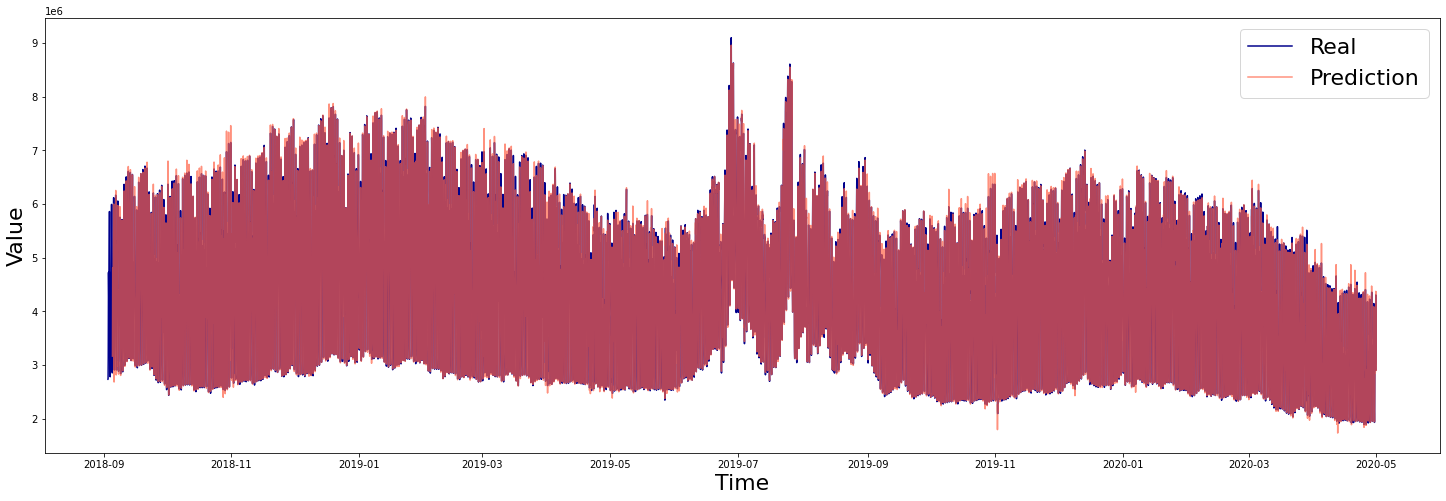

In [ ]:
# Predizioni sul train
plt.figure(figsize=(25, 8))
plt.plot(train['VALORE'][best_arima['min']:], color='darkblue', label='Real')
plt.plot(best_arima['predicted_train_mean'][best_arima['min']:], color='tomato', label='Prediction', alpha=0.7)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

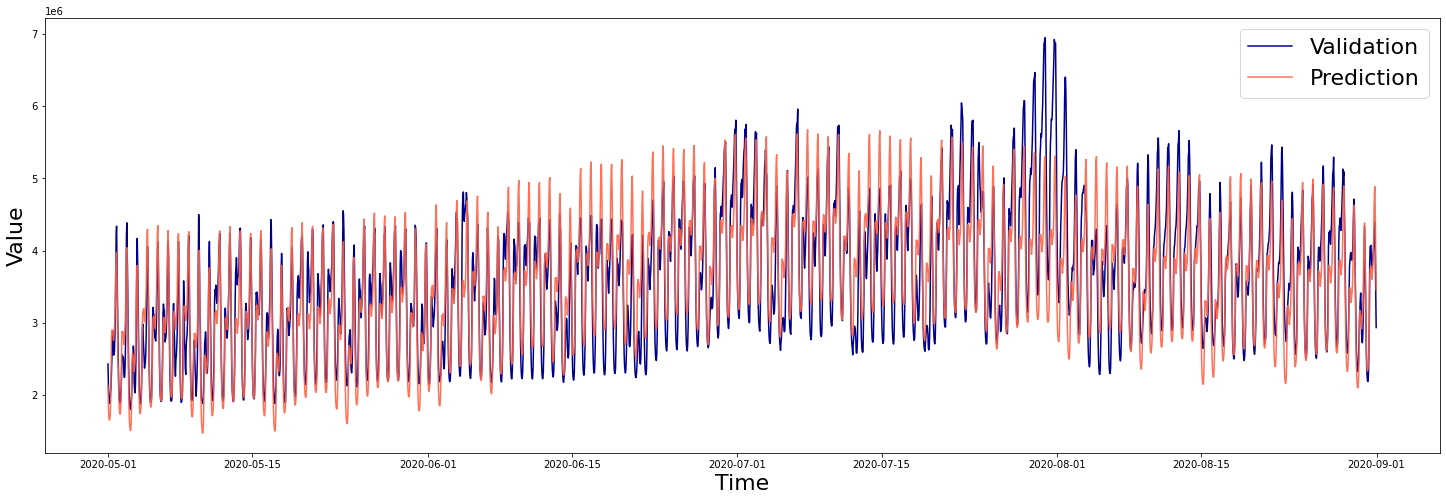

In [ ]:
# Predizioni sul validation
plt.figure(figsize=(25, 8))
plt.plot(validation['VALORE'], color='darkblue', label='Validation')
plt.plot(best_arima['predicted_val_mean'], color='tomato', label='Prediction', alpha=0.9)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

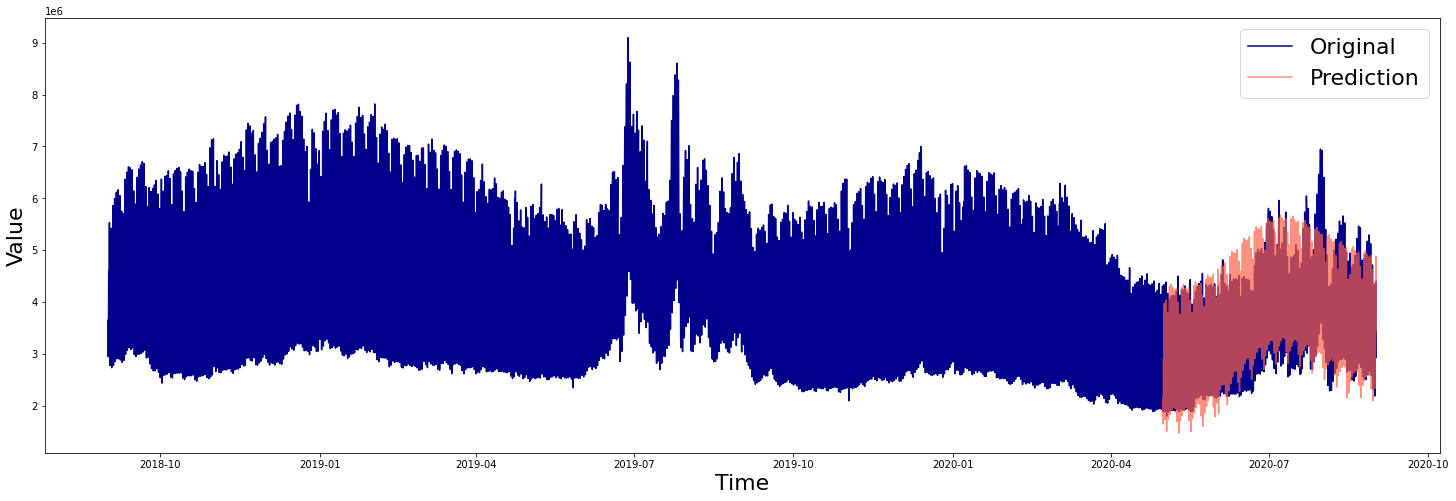

In [ ]:
# Predizioni su train e validation
plt.figure(figsize=(25, 8))
plt.plot(df['VALORE'], color='darkblue', label='Original')
plt.plot(best_arima['predicted_val_mean'], color='tomato', label='Prediction', alpha=0.7)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 8))
fig = best_arima.plot_diagnostics(fig=fig, lags=48)

# Modello UCM

In questa sezione si provano vari modelli UCM, si procede in modo incrementale per ogni componente.

In [ ]:
def UCM_model(lev_tre, train, validation, cycle=False, freq_seasonal=None, exog=None):

    exog_train = np.array(df[exog][:len(train)]) if exog else None
    exog_val = np.array(df[exog][len(train):]) if exog else None

    model = sm.tsa.UnobservedComponents(train['VALORE'],
                                        lev_tre,
                                        cycle=cycle,
                                        seasonal=24, freq_seasonal=freq_seasonal,
                                        exog=exog_train)
    model = model.fit(low_memory=True)
    
    min=model.loglikelihood_burn
    # predict for evaluate on TRAIN
    predicted_train = model.get_prediction(start=train.index[min], end=train.index[-1])
    predicted_train_mean = predicted_train.predicted_mean
    residui_train=train['VALORE'][min:]-predicted_train_mean

    # predict for evaluate on VALIDATION
    predicted_val = model.get_prediction(start=validation.index[0], 
                                         end=validation.index[-1], exog=exog_val)
    predicted_val_mean = predicted_val.predicted_mean
    residui_val=validation['VALORE']-predicted_val_mean
    
    mae_train = mean_absolute_error(train['VALORE'][min:], predicted_train_mean)
    mae_val = mean_absolute_error(validation['VALORE'], predicted_val_mean)
    
    exog_descr = '+'.join(exog) if exog else ''

    stats = {'model': lev_tre, 'exog': exog_descr, 'log-lik': model.llf, 
             'bic': model.bic, 'aic': model.aic, 'MAE-val': mae_val, 'MAE-train': mae_train}
    
    return {'predicted_train_mean': predicted_train_mean, 'predicted_val_mean': predicted_val_mean, 
          'residui_train': residui_train, 'min': min, 'stats': stats}
    
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [ ]:
# UCM per il trend, si provano i 9 tipi di trends

res_ucm = list()
trends = ['rwalk', 'dconstant', 'ntrend', 'llevel', 'lldtrend', 'rwdrift', 'lltrend', 'strend', 'rtrend']
for lev_tre in tqdm(trends):
    freq_seasonal = [{'period':24*7, 'harmonics':15}]
    res_ucm.append(UCM_model(lev_tre, train, validation, freq_seasonal=freq_seasonal))

In [ ]:
# Risultati dei trends
pd.DataFrame([x['stats'] for x in res_ucm])

,model,exog,log-lik,bic,aic,MAE-val,MAE-train
0,rwalk,,-243950.375047,487929.503658,487906.750095,752061.9,102648.6
1,dconstant,,-244398.599131,488825.951825,488803.198262,3645172.2,1023575.9
2,ntrend,,-247810.151644,495649.057058,495626.303288,3645233.1,1023536.3
3,llevel,,-244467.137158,488972.612401,488942.274316,752009.1,103983.0
4,lldtrend,,-244450.448460,488939.234730,488908.896920,742714.1,103958.2
5,rwdrift,,-243933.720316,487896.193990,487873.440633,743458.6,102623.3
6,lltrend,,-245237.138980,490522.200221,490484.277959,13418369.2,105028.5
7,strend,,-245235.252463,490508.842736,490478.504926,13418507.5,105031.0
8,rtrend,,-244712.748644,489454.250645,489431.497288,13096502.3,103951.7


Continuo solo con i trends con i migliori risultati per il MAE

In [ ]:
#whitout covid variable
res_ucm_cycle = list()
trends = ['rwalk', 'llevel', 'lldtrend', 'rwdrift']
for lev_tre in tqdm(trends):
    freq_seasonal = [{'period':24*7, 'harmonics':15}]
    res_ucm_cycle.append(UCM_model(lev_tre, train, validation, cycle=True, freq_seasonal=freq_seasonal))

In [ ]:
# Risultati dei trends
pd.DataFrame([x['stats'] for x in res_ucm_cycle])

,model,exog,log-lik,bic,aic,MAE-val,MAE-train
0,rwalk,,-243917.031485,487872.400504,487842.062970,752060.3,102567.7
1,llevel,,-244433.720327,488915.362572,488877.440654,752009.1,103902.0
2,lldtrend,,-244417.023587,488881.968747,488844.047173,742714.1,103852.9
3,rwdrift,,-243900.371358,487839.079975,487808.742715,743422.4,102531.3


In [ ]:
# Modello UCM con regressori

list_reg = ['lockdown', 'is_weekend', 'is_holiday']
all_combinations = []
for r in range(len(list_reg) + 1):
    combinations_object = itertools.combinations(list_reg, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

reg_combo = [list(x) for x in all_combinations if x != ()]

res_ucm_reg = list()
trends = ['rwalk', 'llevel', 'lldtrend', 'rwdrift']
for lev_tre in tqdm(trends, desc='Trends'):
    for reg in tqdm(reg_combo, desc='reg', leave=False):
        res_ucm_reg.append(UCM_model(lev_tre, train, validation, 
                                 freq_seasonal=[{'period':24*7, 'harmonics':15}], exog=reg))

In [ ]:
# Risultati dei trends
pd.DataFrame([x['stats'] for x in res_ucm_reg])

,model,exog,log-lik,bic,aic,MAE-val,MAE-train
0,rwalk,lockdown,-243950.375047,487939.088179,487908.750095,752061.9,102648.6
1,rwalk,is_weekend,-243949.212070,487936.762224,487906.424139,752058.3,102718.9
2,rwalk,is_holiday,-243950.226430,487938.790944,487908.452860,749291.2,102636.1
3,rwalk,lockdown+is_weekend,-243949.212070,487946.346745,487908.424139,752058.3,102718.9
4,rwalk,lockdown+is_holiday,-243950.226430,487948.375466,487910.452860,749291.2,102636.1
5,rwalk,is_weekend+is_holiday,-243949.103246,487946.129097,487908.206491,750062.4,102703.4
6,rwalk,lockdown+is_weekend+is_holiday,-243949.103246,487955.713619,487910.206491,750062.4,102703.4
7,llevel,lockdown,-244467.137158,488982.196922,488944.274316,752009.1,103983.0
8,llevel,is_weekend,-244465.972538,488979.867682,488941.945076,752005.8,104038.7
9,llevel,is_holiday,-244466.988345,488981.899297,488943.976691,749240.0,103970.3


In [ ]:
UCM_best_model = UCM_model('lldtrend', train, validation,
                           freq_seasonal=[{'period':24*7, 'harmonics':15}], exog=['is_holiday'])

In [ ]:
pd.DataFrame(UCM_best_model['stats'], index=range(1))

,model,exog,log-lik,bic,aic,MAE-val,MAE-train
0,lldtrend,is_holiday,-244450.299658,488948.521578,488910.599316,739937.5,103945.6


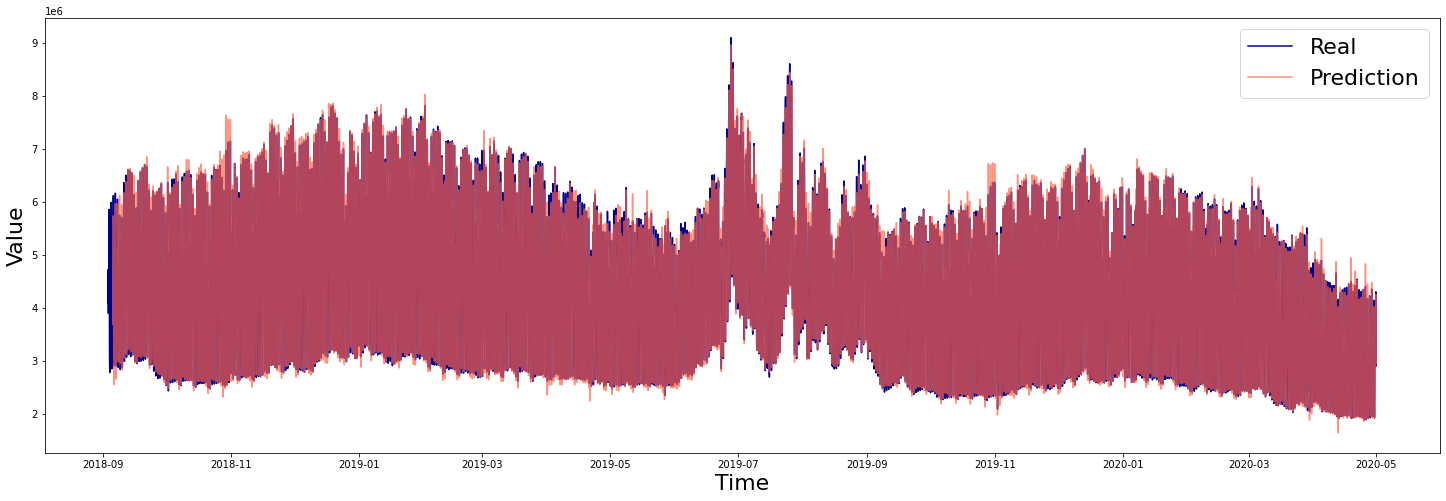

In [ ]:
# Predizioni sul train
plt.figure(figsize=(25, 8))
plt.plot(train['VALORE'][UCM_best_model['min']:], color='darkblue', label='Real')
plt.plot(UCM_best_model['predicted_train_mean'][UCM_best_model['min']:], color='tomato', label='Prediction', alpha=0.7)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

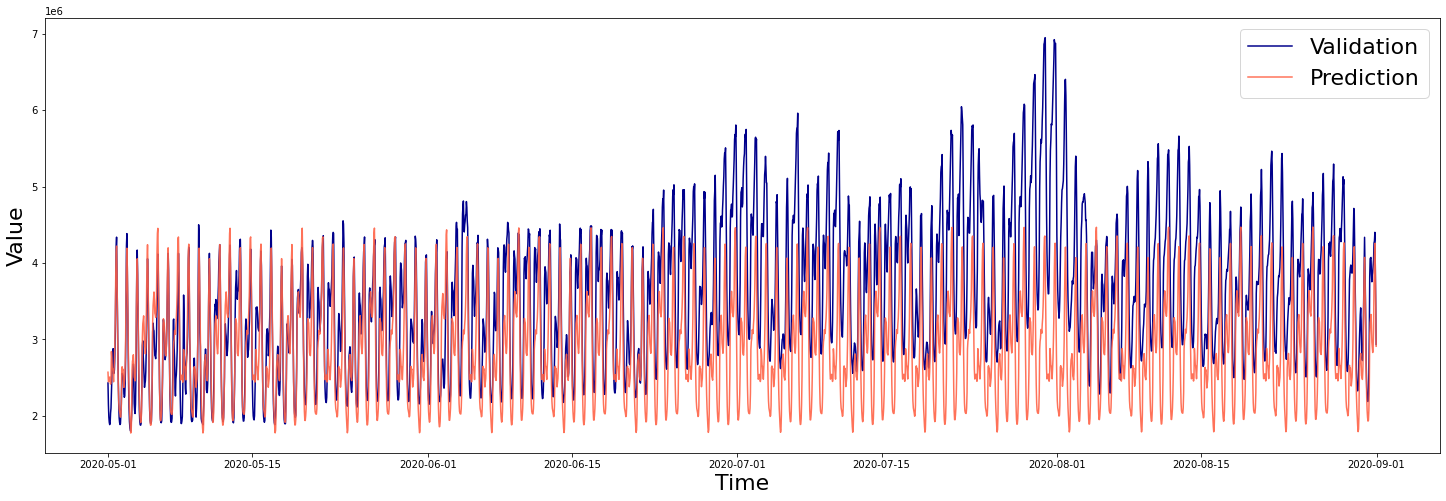

In [ ]:
# Predizioni sul validation
plt.figure(figsize=(25, 8))
plt.plot(validation['VALORE'], color='darkblue', label='Validation')
plt.plot(UCM_best_model['predicted_val_mean'], color='tomato', label='Prediction', alpha=0.9)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

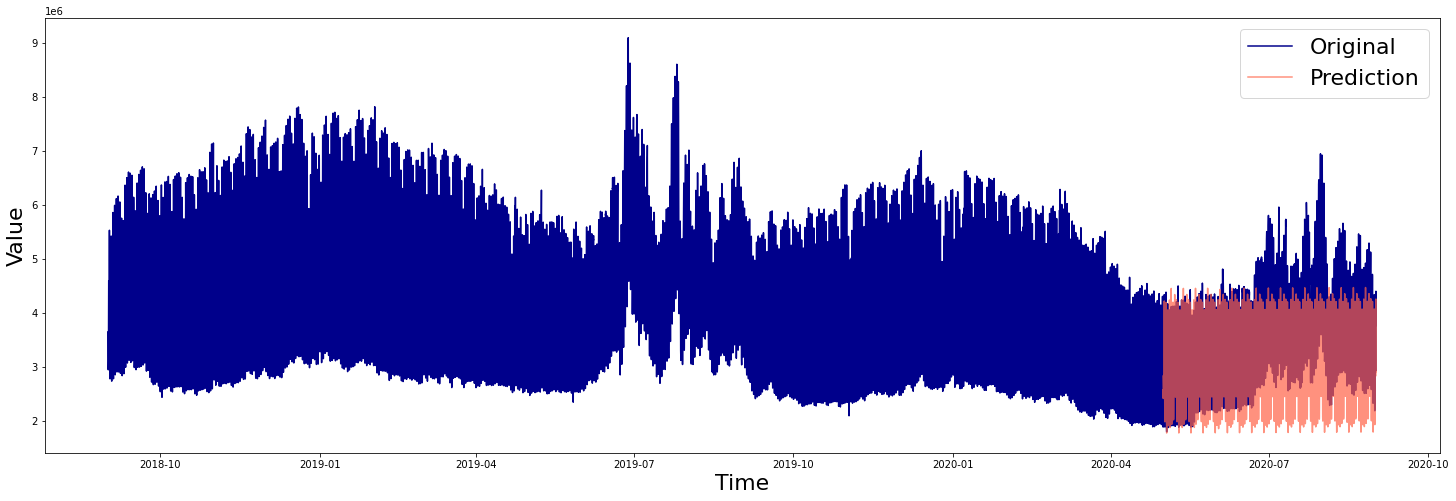

In [ ]:
# Predizioni su train e validation
#total_pred = UCM_best_model['predicted_train_mean'][UCM_best_model['min']:].append(UCM_best_model['predicted_val_mean'])
plt.figure(figsize=(25, 8))
plt.plot(df['VALORE'], color='darkblue', label='Original')
plt.plot(UCM_best_model['predicted_val_mean'], color='tomato', label='Prediction', alpha=0.7)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

# Modello Machine Learning

Si testano vari modelli di RNN, in particolare LSTM e GRU. Per rendere più equo il confronto, si tilizzano le stesse architetture:
- 1 layer da 128 neuroni
- 2 layer da 64 e 32 neuroni

In [ ]:
# Funzioni di preparazione dei dati

# Creazione del formato [samples, timesteps] per la rete neurale
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = list(sequence['VALORE'][i:end_ix]), list(sequence['VALORE'][end_ix:out_end_ix])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def data_preparation(n_steps_in, n_steps_out, train_st, n_features=1):
    # Creazione della sequenza
    X, y = split_sequence(train_st, n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

# Funzione per lo scaler dei valori
def preprocess_data(X, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=(0.01, 1))
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [ ]:
#Train / validation split
train=df.loc[:"2020-07-01 23:00:00"]
validation=df.loc["2020-07-02 00:00:00":]

#Preprocess input data by standardise features
train['VALORE'], scaler = preprocess_data(train.values)
res_RNN = list()

In [ ]:
n_features = 1
n_steps_in, n_steps_out= 24*30, 24*61
X, y = data_preparation(n_steps_in, n_steps_out, train)
batch_size = 1

In [ ]:
# Definizione della rete GRU un livello
model = Sequential()
model.add(GRU(128, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(Dropout(0.33))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')

hisory = model.fit(X, y, epochs=5, verbose=1, shuffle=False)

In [ ]:
# Predizioni
x_input = np.array(train_st[-n_steps_in:])
yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
pred = pd.DataFrame({'Value': yhat[0], 'datetime': validation.index})
pred.set_index('datetime', inplace=True)
pred['Value'] = scaler.inverse_transform(pred)
MAE_train = mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y)
MAE_val = mean_absolute_error(validation['VALORE'], pred['Value'])

res_RNN.append({'Modello':'GRU - 1 layer', 'MAE_train': MAE_train, 'MAE_val': MAE_val})

In [ ]:
# Definizione della rete LSTM 1 livello
model = Sequential()
model.add(LSTM(128, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.33))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae', metrics='mae')

history = model.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
435/435 [==============================] - 271s 617ms/step - loss: 0.1273 - mae: 0.1273
Epoch 2/5
435/435 [==============================] - 263s 604ms/step - loss: 0.0780 - mae: 0.0780
Epoch 3/5
435/435 [==============================] - 262s 601ms/step - loss: 0.0672 - mae: 0.0672
Epoch 4/5
435/435 [==============================] - 261s 600ms/step - loss: 0.0653 - mae: 0.0653
Epoch 5/5
435/435 [==============================] - 261s 600ms/step - loss: 0.0672 - mae: 0.0672


In [ ]:
# Predizioni
x_input = np.array(train_st[-n_steps_in:])
yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
pred = pd.DataFrame({'Value': yhat[0], 'datetime': validation.index})
pred.set_index('datetime', inplace=True)
pred['Value'] = scaler.inverse_transform(pred)
MAE_train = mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y)
MAE_val = mean_absolute_error(validation['VALORE'], pred['Value'])

res_RNN.append({'Modello':'LSTM - 1 layer', 'MAE_train': MAE_train, 'MAE_val': MAE_val})


In [ ]:
# Definizione della rete GRU 2 livelli
model = Sequential()
model.add(GRU(64, input_shape=(n_steps_in, n_features), return_sequences=True))
model.add(Dropout(0.33))
model.add(GRU(32, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.33))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae', metrics='mae')

history = model.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
435/435 [==============================] - 265s 600ms/step - loss: 0.1445 - mae: 0.1445
Epoch 2/5
435/435 [==============================] - 261s 601ms/step - loss: 0.1007 - mae: 0.1007
Epoch 3/5
435/435 [==============================] - 261s 600ms/step - loss: 0.0835 - mae: 0.0835
Epoch 4/5
435/435 [==============================] - 261s 601ms/step - loss: 0.0801 - mae: 0.0801
Epoch 5/5
435/435 [==============================] - 263s 604ms/step - loss: 0.0787 - mae: 0.0787


In [ ]:
# Predizioni
x_input = np.array(train_st[-n_steps_in:])
yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
pred = pd.DataFrame({'Value': yhat[0], 'datetime': validation.index})
pred.set_index('datetime', inplace=True)
pred['Value'] = scaler.inverse_transform(pred)
MAE_train = mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y)
MAE_val = mean_absolute_error(validation['VALORE'], pred['Value'])

res_RNN.append({'Modello':'GRU - 2 layers', 'MAE_train': MAE_train, 'MAE_val': MAE_val})

In [ ]:
# Definizione della rete neurale LSTM 2 livelli
model = Sequential()
model.add(LSTM(64, input_shape=(n_steps_in, n_features), return_sequences=True))
model.add(Dropout(0.33))
model.add(LSTM(32, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.33))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae', metrics='mae')

history = model.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
435/435 [==============================] - 270s 612ms/step - loss: 0.1459 - mae: 0.1459
Epoch 2/5
435/435 [==============================] - 266s 612ms/step - loss: 0.1348 - mae: 0.1348
Epoch 3/5
435/435 [==============================] - 267s 613ms/step - loss: 0.1349 - mae: 0.1349
Epoch 4/5
435/435 [==============================] - 265s 610ms/step - loss: 0.1367 - mae: 0.1367
Epoch 5/5
435/435 [==============================] - 266s 612ms/step - loss: 0.1410 - mae: 0.1410


In [ ]:
# Predizioni
x_input = np.array(train_st[-n_steps_in:])
yhat = model.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
pred = pd.DataFrame({'Value': yhat[0], 'datetime': validation.index})
pred.set_index('datetime', inplace=True)
pred['Value'] = scaler.inverse_transform(pred)
MAE_train = mean_absolute_error(scaler.inverse_transform(model.predict(X, batch_size=batch_size)), y)
MAE_val = mean_absolute_error(validation['VALORE'], pred['Value'])

res_RNN.append({'Modello':'LSTM - 2 layers', 'MAE_train': MAE_train, 'MAE_val': MAE_val})

In [ ]:
pd.DataFrame(res_RNN, index=range(4))

,Modello,MAE_train,MAE_val
0,GRU - 1 layer,2979502.0,970576.5
1,LSTM - 1 layer,3029389.6,928614.0
2,GRU - 2 layers,3149814.3,786970.3
3,LSTM - 2 layers,2964050.3,1071215.0


Il miglior modello per MAE sul validation è la rete GRU con dua layer

In [ ]:
# Definizione della rete GRU 2 livelli
best_rnn = Sequential()
best_rnn.add(GRU(64, input_shape=(n_steps_in, n_features), return_sequences=True))
best_rnn.add(Dropout(0.33))
best_rnn.add(GRU(32, input_shape=(n_steps_in, n_features)))
best_rnn.add(Dropout(0.33))
best_rnn.add(Dense(n_steps_out))
best_rnn.compile(optimizer='adam', loss='mae', metrics='mae')

history = best_rnn.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
435/435 [==============================] - 237s 536ms/step - loss: 0.1467 - mae: 0.1467
Epoch 2/5
435/435 [==============================] - 233s 535ms/step - loss: 0.1060 - mae: 0.1060
Epoch 3/5
435/435 [==============================] - 233s 535ms/step - loss: 0.0829 - mae: 0.0829
Epoch 4/5
435/435 [==============================] - 234s 537ms/step - loss: 0.0806 - mae: 0.0806
Epoch 5/5
435/435 [==============================] - 232s 534ms/step - loss: 0.0778 - mae: 0.0778


In [ ]:
# Predizioni
x_input = np.array(train_st[-n_steps_in:])
yhat = best_rnn.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
pred = pd.DataFrame({'Value': yhat[0], 'datetime': validation.index})
pred.set_index('datetime', inplace=True)
pred['Value'] = scaler.inverse_transform(pred)
MAE_train = mean_absolute_error(scaler.inverse_transform(best_rnn.predict(X, batch_size=batch_size)), y)
MAE_val = mean_absolute_error(validation['VALORE'], pred['Value'])

In [ ]:
# prediction on VALIDATION
plt.figure(figsize=(25, 8))
plt.plot(df['VALORE'], color='darkblue', label='Validation')
plt.plot(pred['Value'], color='tomato', label='Prediction', alpha=0.9)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

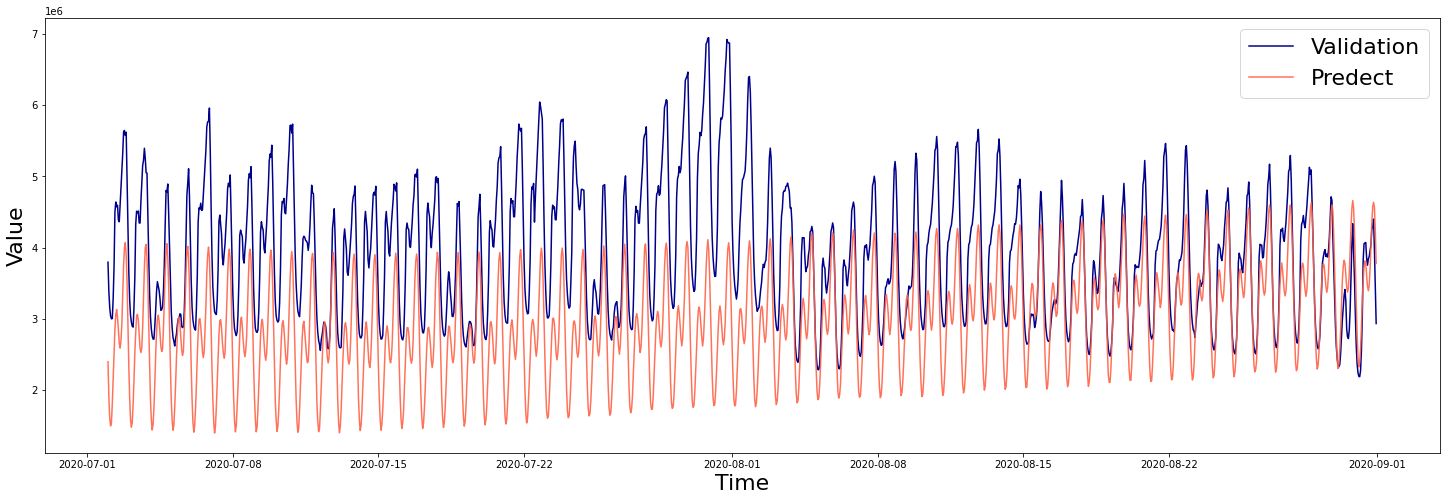

In [ ]:
# prediction on VALIDATION
plt.figure(figsize=(25, 8))
plt.plot(validation['VALORE'], color='darkblue', label='Validation')
plt.plot(pred['Value'], color='tomato', label='Predect', alpha=0.9)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

# Predizioni



In [ ]:
start = "2018-09-01 00:00:00"
end = "2020-10-31 23:00:00"
start_pred = pd.to_datetime("2020-09-01 00:00:00",  format = "%Y-%m-%d %H:%M:%S")
end_pred = pd.to_datetime('2020-10-31 23:00:00',  format = "%Y-%m-%d %H:%M:%S")
                              

In [ ]:
# Creazione del dataframe finale
range_date = pd.date_range(start=start, end=end, freq='H')
range_date = range_date.to_frame()
range_date.columns = ['datetime']
df_final = pd.merge(range_date, df['VALORE'], how='left', on='datetime')
df_final.set_index(df_final['datetime'], inplace=True)
df_final['is_holiday'] = df_final['datetime'].apply(lambda x: 1 if x in IT_holidays else 0)

In [ ]:
# Predizioni sul modello ARIMA
four_sett = DeterministicProcess(pd.date_range(start=start, end=end_pred, freq='H'), 
                                 period=168, fourier=5)
four_ann = DeterministicProcess(pd.date_range(start=start, end=end_pred, freq='H'),
                                period=24*365, fourier=5)
four=four_sett.in_sample().merge(four_ann.in_sample(), left_index=True, right_index=True)

# regressori per il train
x_train=four[:len(df)]
x_train_reg = pd.merge(x_train, df['is_holiday'], left_index=True, right_index=True)

# regressori per il test
x_val=four[len(df):]
x_val_reg = pd.merge(x_val, df_final['is_holiday'], left_index=True, right_index=True)

In [ ]:
best_ARIMA = sm.tsa.statespace.SARIMAX(df['VALORE'],order=(2, 0, 2), 
                                       seasonal_order=(1, 1, 1, 24), exog=x_train_reg,
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)

best_ARIMA = best_ARIMA.fit(low_memory=True)

In [ ]:
pred = best_ARIMA.get_prediction(start=start_pred, end=end_pred, exog=x_val_reg)
forecast_ARIMA = pd.DataFrame({'ARIMA':pred.predicted_mean})

forecast_ARIMA.to_csv(path+'/forecast_ARIMA.csv')

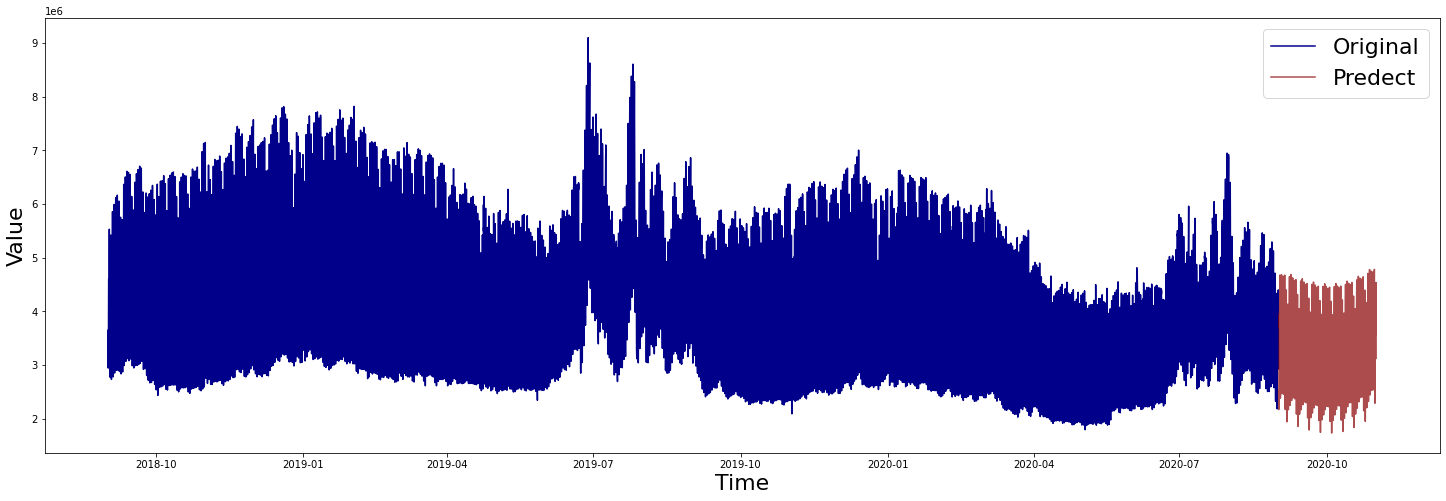

In [ ]:
# Predizioni
plt.figure(figsize=(25, 8))
plt.plot(df['VALORE'], color='darkblue', label='Original')
plt.plot(forecast_ARIMA['ARIMA'], color='darkred', label='Predect', alpha=0.7)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

In [ ]:
# Predizioni UCM
best_UCM = sm.tsa.UnobservedComponents(df['VALORE'], 'lldtrend', seasonal=24, 
                                       freq_seasonal = [{'period':24*7, 'harmonics':15}],
                                       exog=df['is_holiday'])

best_UCM = best_UCM.fit(low_memory=True)

In [ ]:
pred = best_UCM.get_prediction(start=start_pred, end=end_pred, exog=x_val_reg['is_holiday'])
forecast_UCM = pd.DataFrame({'UCM':pred.predicted_mean})

forecast_UCM.to_csv(path+'/forecast_UCM.csv')

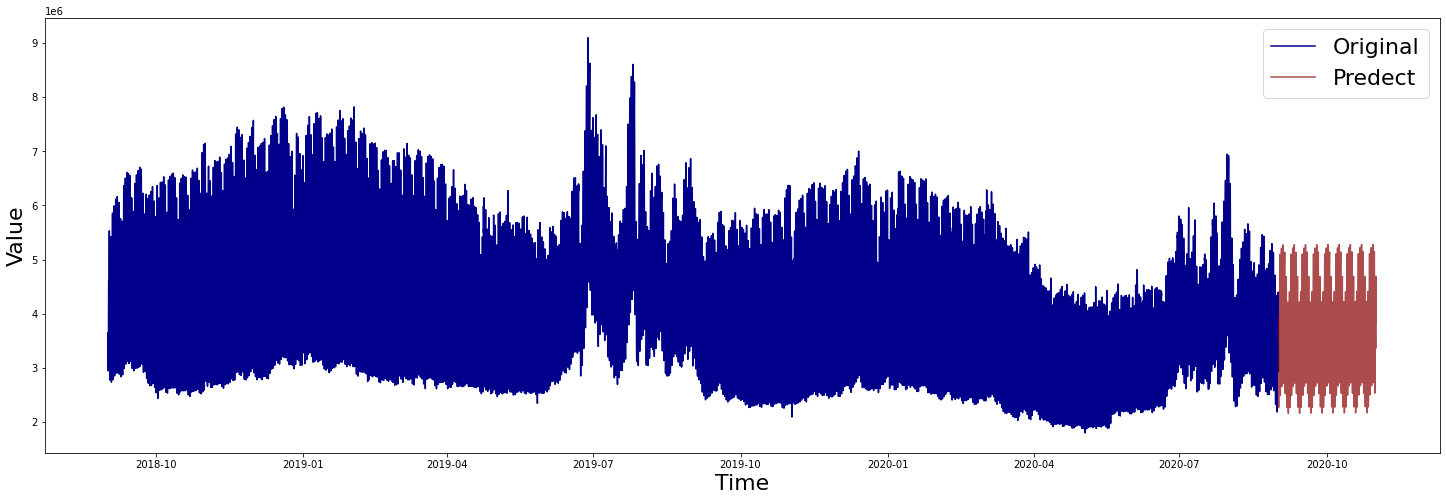

In [ ]:
# Predizioni
plt.figure(figsize=(25, 8))
plt.plot(df['VALORE'], color='darkblue', label='Original')
plt.plot(forecast_UCM['UCM'], color='darkred', label='Predect', alpha=0.7)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

In [ ]:
train=df.copy()[['VALORE']]
train['VALORE'], scaler = preprocess_data(train.values)

n_features = 1
n_steps_in, n_steps_out= 24*30, 24*61
X, y = data_preparation(n_steps_in, n_steps_out, train)
batch_size = 1

In [ ]:
# Definizione della rete GRU 2 livelli
best_rnn = Sequential()
best_rnn.add(GRU(64, input_shape=(n_steps_in, n_features), return_sequences=True))
best_rnn.add(Dropout(0.33))
best_rnn.add(GRU(32, input_shape=(n_steps_in, n_features)))
best_rnn.add(Dropout(0.33))
best_rnn.add(Dense(n_steps_out))
best_rnn.compile(optimizer='adam', loss='mae', metrics='mae')

history = best_rnn.fit(X, y, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
481/481 [==============================] - 263s 540ms/step - loss: 0.1436 - mae: 0.1436
Epoch 2/5
481/481 [==============================] - 260s 540ms/step - loss: 0.1035 - mae: 0.1035
Epoch 3/5
481/481 [==============================] - 260s 540ms/step - loss: 0.0777 - mae: 0.0777
Epoch 4/5
481/481 [==============================] - 259s 537ms/step - loss: 0.0727 - mae: 0.0727
Epoch 5/5
481/481 [==============================] - 259s 539ms/step - loss: 0.0711 - mae: 0.0711


In [ ]:
x_input = np.array(train_st[-n_steps_in:])
yhat = best_rnn.predict(x_input.reshape(1, n_steps_in, n_features), verbose=0)
range_pred = pd.date_range(start=start_pred, end=end_pred, freq='H')
forecast_ML = pd.DataFrame({'ML': yhat[0], 'datetime': range_pred})
forecast_ML.set_index('datetime', inplace=True)
forecast_ML['ML'] = scaler.inverse_transform(pred)

forecast_ML.to_csv(path+'/forecast_ML.csv')

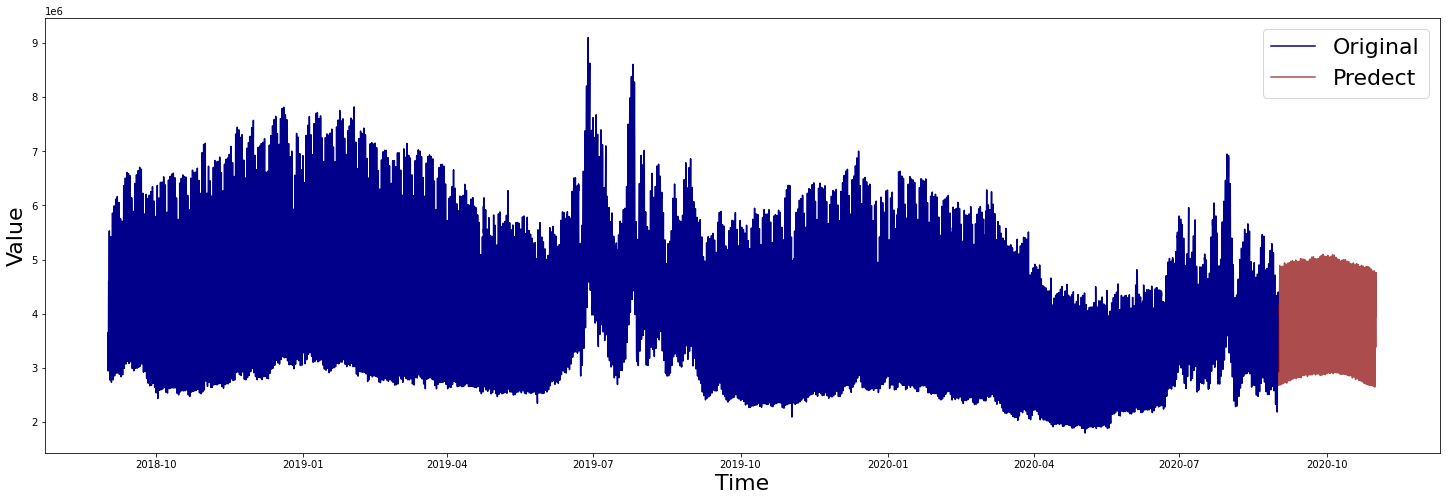

In [ ]:
# Plot Predizioni
plt.figure(figsize=(25, 8))
plt.plot(df['VALORE'], color='darkblue', label='Original')
plt.plot(forecast_ML['ML'], color='darkred', label='Predect', alpha=0.7)
plt.ylabel('Value', fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.legend(prop={'size': 22})
plt.show()

In [ ]:
df_arima = pd.read_csv("/content/drive/MyDrive/SDMaTSA/forecast_ARIMA.csv", 
                 index_col=False, sep=",", header=0, low_memory=False, parse_dates=[0])
df_ucm = pd.read_csv("/content/drive/MyDrive/SDMaTSA/forecast_UCM.csv", 
                 index_col=False, sep=",", header=0, low_memory=False, parse_dates=[0])
df_ml = pd.read_csv("/content/drive/MyDrive/SDMaTSA/forecast_ML.csv", 
                 index_col=False, sep=",", header=0, low_memory=False, parse_dates=[0])

In [ ]:
df = pd.merge(df_arima, df_ucm, how='inner', on='Unnamed: 0')
df = df.set_index('Unnamed: 0')
df_ml = df_ml.set_index('datetime')
df = pd.merge(df, df_ml, how='inner', left_index=True, right_index=True)
df['Data'] = df.index.date
df['Ora'] = df.index.hour+1
df = df[['Data', 'Ora', 'ARIMA', 'UCM', 'ML']]

In [ ]:
df.to_csv('/content/drive/MyDrive/SDMaTSA/SDMTSA_850369_1.csv', index=False, sep=';')